In [149]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
import utils_fc as utils
from scipy.optimize import minimize
from scipy import stats
from tqdm import tqdm

In [151]:
subject_id_default = 13620
dataloader = utils.MRIDataLoader()
TE_times = dataloader.get_TE_times()
roi_dict, roi_id_dict = dataloader.get_roi_dicts()
info_dict = dataloader.get_info_dict()
thresh_default = 0.9
subject_ids = dataloader.get_subject_ids()
is_pre_term = dataloader.get_info(1) < 26
pre_term_ids = np.arange(subject_ids.shape[0])[is_pre_term]
full_term_ids = np.arange(subject_ids.shape[0])[~is_pre_term]
root_path = 'data/arrays/'

WM_T2 = 66.1
GM_T2 = 74.2

In [152]:
data_full, seg_full = dataloader.load_all_roi_WM_GM_thresh_mono_data(thresh_default, 'fullterm')
data_pre, seg_pre = dataloader.load_all_roi_WM_GM_thresh_mono_data(thresh_default, 'preterm')

### Calculate Myelin percentage on Full Term

In [153]:
# get the data we want - mono and WM + GM > thresh
WM_id, GM_id = roi_dict['WM'], roi_dict['GM']
is_thresh = (seg_full[:,WM_id] + seg_full[:,GM_id]) > thresh_default
is_mono = utils.is_monotonic_index(data_full)
is_mono_thresh = (is_mono * is_thresh).astype(bool)

data = data_full[is_mono_thresh]
seg = seg_full[is_mono_thresh]

WM_GM_factor = seg[:,GM_id] / (seg[:,GM_id] + seg[:,WM_id])

In [154]:
nb_vox = 1000
nb_rand_vox = np.random.randint(low=0, high=data.shape[0], size=nb_vox)
data_fit = data[nb_rand_vox]
seg_fit = seg[nb_rand_vox]
WM_GM_factor_fit = WM_GM_factor[nb_rand_vox]

### First fit with WLLS to get an estimate on S0

c:\Users\fl_cl\OneDrive - University College London\Visual Studio 2017\Biomedical-imaging\report\utils_fc.py:76: RuntimeWarning: divide by zero encountered in divide
  T2 = (-1) / X[:,1]


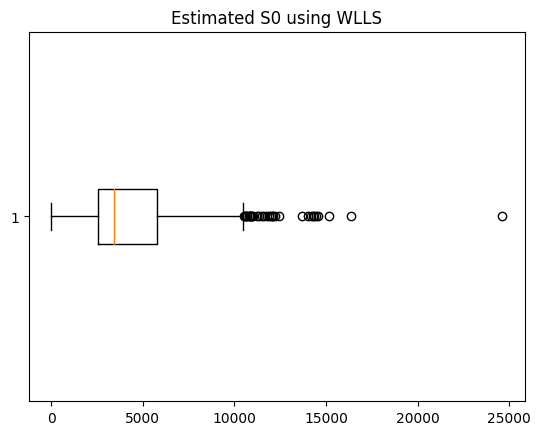

In [155]:
_, S0_fit = utils.lsqr_weighted(data_fit[:,1:], np.ones(nb_vox), TE_times[1:])    # fit S0 without TE-13 signal

plt.boxplot(S0_fit, vert=False)
plt.title('Estimated S0 using WLLS')
plt.show()

### Use priors to get an estimate on myelin

### fit with 4 compartment model

In [156]:
problem_four_compartment = utils.create_problem_to_minimize('four_compartment')
answers_4 = np.zeros(shape=(nb_vox, 4))

for vox_id, vox_data in tqdm(enumerate(data_fit), ascii=True, total=nb_vox):
    x0 = np.array([20, 70, 0.3, 0.5])
    args = (vox_data, TE_times, S0_fit[vox_id], WM_T2, GM_T2, WM_GM_factor_fit[vox_id])
    
    solution = minimize(**problem_four_compartment, x0=x0, args=args, method='L-BFGS-B')
    for param_id in range(x0.shape[0]):
        answers_4[vox_id, param_id] = solution['x'][param_id]

is_myelin_full = ((answers_4[:,0] < 35) * (answers_4[:,0] > 5)).astype(bool)
myelin_v_full = answers_4[:,2] * answers_4[:,3]
myelin_proportion_full = (myelin_v_full[is_myelin_full].sum() / nb_vox) * 100
    

  1%|1         | 10/1000 [00:00<00:09, 99.03it/s]c:\Users\fl_cl\OneDrive - University College London\Visual Studio 2017\Biomedical-imaging\report\utils_fc.py:131: RuntimeWarning: divide by zero encountered in divide
  T2_inv = 1/T2
100%|##########| 1000/1000 [00:16<00:00, 58.94it/s]


C:\Users\fl_cl\AppData\Local\Temp\ipykernel_24612\2728029460.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


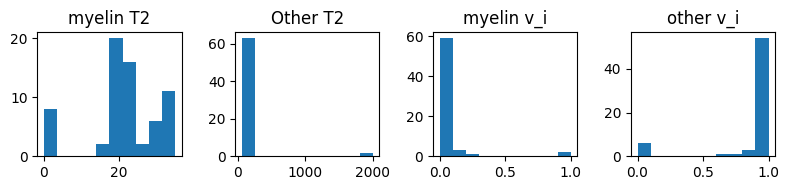

In [157]:
fig, axs = plt.subplots(1,4, figsize=(8,2))

axs[0].hist(answers_4[answers_4[:,0] < 35, 0])
axs[0].set_title('myelin T2')
axs[1].hist(answers_4[answers_4[:,0] < 35,1])
axs[1].set_title('Other T2')
axs[2].hist(answers_4[answers_4[:,0] < 35,2] * answers_4[answers_4[:,0] < 35,3])
axs[2].set_title('myelin v_i')
axs[3].hist(answers_4[answers_4[:,0] < 35,2] * (1 - answers_4[answers_4[:,0] < 35,3]))
axs[3].set_title('other v_i')
fig.tight_layout()
fig.show()

### Fit on full term

In [162]:
nb_sample = 100
nb_bootstrap = 200

# get the data we want - mono and WM + GM > thresh
WM_id, GM_id = roi_dict['WM'], roi_dict['GM']

data = data_full
seg = seg_full

WM_GM_factor = seg[:,GM_id] / (seg[:,GM_id] + seg[:,WM_id])

myelin_proportion_full = np.zeros(nb_bootstrap)
myelin_v_full = []

for i in tqdm(range(nb_bootstrap), ascii=True):
    nb_rand_vox = np.random.randint(low=0, high=data.shape[0], size=nb_sample)
    data_fit = data[nb_rand_vox]
    seg_fit = seg[nb_rand_vox]
    WM_GM_factor_fit = WM_GM_factor[nb_rand_vox]

    _, S0_fit = utils.lsqr_weighted(data_fit[:,1:], np.ones(nb_vox), TE_times[1:])

    problem_four_compartment = utils.create_problem_to_minimize('four_compartment')
    answers_4 = np.zeros(shape=(nb_vox, 4))

    for vox_id, vox_data in enumerate(data_fit):
        x0 = np.array([20, 70, 0.3, 0.5])
        args = (vox_data, TE_times, S0_fit[vox_id], WM_T2, GM_T2, WM_GM_factor_fit[vox_id])
        
        solution = minimize(**problem_four_compartment, x0=x0, args=args, method='L-BFGS-B')
        for param_id in range(x0.shape[0]):
            answers_4[vox_id, param_id] = solution['x'][param_id]

    is_myelin_full = ((answers_4[:,0] < 35) * (answers_4[:,0] > 5)).astype(bool)
    myelin_v_full.append((answers_4[:,2] * answers_4[:,3])[is_myelin_full])
    myelin_proportion_full[i] = (myelin_v_full[i].sum() / nb_vox) * 100
    

100%|##########| 200/200 [05:49<00:00,  1.75s/it]


### Now fit on Pre Term

In [163]:
nb_sample = 100
nb_bootstrap = 200


data = data_pre
seg = seg_pre

WM_GM_factor = seg[:,GM_id] / (seg[:,GM_id] + seg[:,WM_id])

myelin_proportion_pre = np.zeros(nb_bootstrap)
myelin_v_pre = []

for i in tqdm(range(nb_bootstrap), ascii=True):
    nb_rand_vox = np.random.randint(low=0, high=data.shape[0], size=nb_sample)
    data_fit = data[nb_rand_vox]
    seg_fit = seg[nb_rand_vox]
    WM_GM_factor_fit = WM_GM_factor[nb_rand_vox]

    _, S0_fit = utils.lsqr_weighted(data_fit[:,1:], np.ones(nb_vox), TE_times[1:])

    problem_four_compartment = utils.create_problem_to_minimize('four_compartment')
    answers_4 = np.zeros(shape=(nb_vox, 4))

    for vox_id, vox_data in enumerate(data_fit):
        x0 = np.array([20, 70, 0.3, 0.5])
        args = (vox_data, TE_times, S0_fit[vox_id], WM_T2, GM_T2, WM_GM_factor_fit[vox_id])
        
        solution = minimize(**problem_four_compartment, x0=x0, args=args, method='L-BFGS-B')
        for param_id in range(x0.shape[0]):
            answers_4[vox_id, param_id] = solution['x'][param_id]

    is_myelin_pre = ((answers_4[:,0] < 35) * (answers_4[:,0] > 5)).astype(bool)
    myelin_v_pre.append((answers_4[:,2] * answers_4[:,3])[is_myelin_pre])
    myelin_proportion_pre[i] = (myelin_v_pre[i].sum() / nb_vox) * 100
    

100%|##########| 200/200 [06:00<00:00,  1.80s/it]


### Result

In [164]:
print(f'Myeline proportions after fitting {nb_vox} voxels')
print(f'Full Term: {myelin_proportion_full.mean():.5f}%')
print(f'Pre Term : {myelin_proportion_pre.mean():.5f}%')

Myeline proportions after fitting 1000 voxels
Full Term: 0.01868%
Pre Term : 0.02565%


C:\Users\fl_cl\AppData\Local\Temp\ipykernel_24612\1329323955.py:29: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


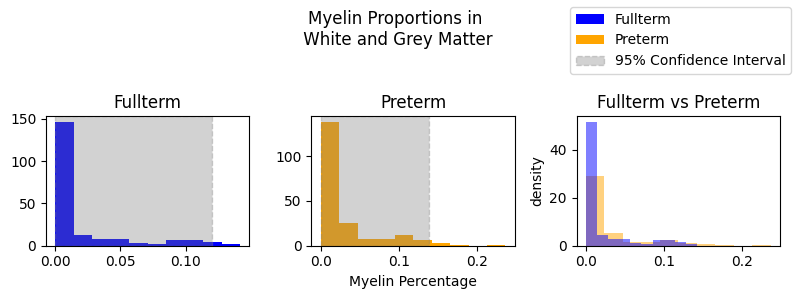

In [183]:
fig, axs = plt.subplots(1,3, figsize=(8,3))

col_interval = 'gray'
col_full = 'blue'
col_pre = 'orange'
alpha = 0.35

full_bounds = np.percentile(myelin_proportion_full, [2.5, 50, 97.5])
pre_bounds = np.percentile(myelin_proportion_pre, [2.5, 50, 97.5])

axs[0].hist(myelin_proportion_full, color=col_full, label='Fullterm')
axs[0].axvspan(xmin=full_bounds[0], xmax=full_bounds[2], color=col_interval, linestyle='--', alpha=alpha)
axs[0].set_title('Fullterm')

axs[1].hist(myelin_proportion_pre, color=col_pre, label='Preterm')
axs[1].axvspan(xmin=pre_bounds[0], xmax=pre_bounds[2], color=col_interval, linestyle='--', alpha=alpha, label='95% Confidence Interval')
axs[1].set_title('Preterm')

axs[2].hist(myelin_proportion_pre, color=col_pre, alpha=0.5, density=True)
axs[2].hist(myelin_proportion_full, color=col_full, alpha=0.5, density=True)
axs[2].set_title('Fullterm vs Preterm')
axs[2].set_ylabel('density')
axs[1].set_xlabel('Myelin Percentage')


fig.suptitle('Myelin Proportions in\n White and Grey Matter\n')
fig.tight_layout()
fig.legend()
fig.show()

In [186]:
print(f'Myelin - Full vs Pre')
print(f'Full: Median proportion: {full_bounds[1]:6.4f}, Interval: ({full_bounds[0]:6.4f}, {full_bounds[2]:6.4f})')
print(f'Pre : Median proportion: {pre_bounds[1]:6.4f}, Interval: ({pre_bounds[0]:6.4f}, {pre_bounds[2]:6.4f})')

Myelin - Full vs Pre
Full: Median proportion: 0.0012, Interval: (0.0000, 0.1200)
Pre : Median proportion: 0.0017, Interval: (0.0000, 0.1380)
